Link for this assignment [here](http://apmonitor.com/do/index.php/Main/OrthogonalCollocation)

# Exercise 1


Objective: Solve a differential equation with orthogonal collocation on finite elements. Create a MATLAB or Python script to simulate and display the results. Estimated Time: 2-3 hours

Solve the following differential equation from time 0 to 1 with orthogonal collocation on finite elements with 4 nodes for discretization in time.

``` 5 dx/dt = -x2 + u ```

Specify the initial condition for x as 0 and the value of the input, u, as 4. Compare the solution result with 2-6 time points (nodes). Report the solution at the final time for each and comment on how the solution changes with an increase in the number of nodes.

apm 10.32.114.116_gk_model10 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            2
   Intermediates:            0
   Connections  :            0
   Equations    :            1
   Residuals    :            1
 
 Variable time shift OFF
 Number of state variables:              2
 Number of total equations: -            2
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

****************************************************************************

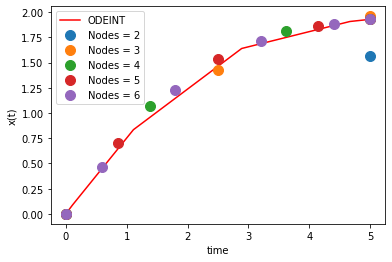

In [21]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# final time
tf = 5.0

# solve with ODEINT (for comparison)
def model(t,x):
    u = 4.0
    return (-x**2 + u)/5.0

# t = np.linspace(0,tf,20)
y0 = np.array([0])
sol = solve_ivp(model,(0,tf), y0)
# print(sol)
plt.figure(1)
plt.plot(sol.t,sol.y.flatten(),'r-',label='ODEINT')

# ----------------------------------------------------
# Approach #1 - Write the model equations in Python
# ----------------------------------------------------
# define collocation matrices
def colloc(n):
    if (n==2):
        NC = np.array([[1.0]])
    if (n==3):
        NC = np.array([[0.75,-0.25], \
                       [1.00, 0.00]])
    if (n==4):
        NC = np.array([[0.436,-0.281, 0.121], \
                       [0.614, 0.064, 0.0461], \
                       [0.603, 0.230, 0.167]])
    if (n==5):
        NC = np.array([[0.278, -0.202, 0.169, -0.071], \
                       [0.398,  0.069, 0.064, -0.031], \
                       [0.387,  0.234, 0.278, -0.071], \
                       [0.389,  0.222, 0.389,  0.000]])
    if (n==6):
        NC = np.array([[0.191, -0.147, 0.139, -0.113, 0.047],
                       [0.276,  0.059, 0.051, -0.050, 0.022],
                       [0.267,  0.193, 0.252, -0.114, 0.045],
                       [0.269,  0.178, 0.384,  0.032, 0.019],
                       [0.269,  0.181, 0.374,  0.110, 0.067]])
    return NC

# define collocation points from Lobatto quadrature
def tc(n):
    if (n==2):
        time = np.array([0.0,1.0])
    if (n==3):
        time = np.array([0.0,0.5,1.0])
    if (n==4):
        time = np.array([0.0, \
                         0.5-np.sqrt(5)/10.0, \
                         0.5+np.sqrt(5)/10.0, \
                         1.0])
    if (n==5):
        time = np.array([0.0,0.5-np.sqrt(21)/14.0, \
                         0.5,0.5+np.sqrt(21)/14.0, 1])
    if (n==6):
        time = np.array([0.0, \
                         0.5-np.sqrt((7.0+2.0*np.sqrt(7.0))/21.0)/2.0, \
                         0.5-np.sqrt((7.0-2.0*np.sqrt(7.0))/21.0)/2.0, \
                         0.5+np.sqrt((7.0-2.0*np.sqrt(7.0))/21.0)/2.0, \
                         0.5+np.sqrt((7.0+2.0*np.sqrt(7.0))/21.0)/2.0, \
                         1.0])
    return time*tf


# solve with SciPy fsolve
def myFunction(z,*param):
    n = param[0]
    m = param[1]
    # rename z as x and xdot variables
    x = np.empty(n-1)
    xdot = np.empty(n-1)
    x[0:n-1] = z[0:n-1]
    xdot[0:n-1] = z[n-1:m]

    # initial condition (x0)
    x0 = 0.0
    # input parameter (u)
    u = 4.0
    # final time
    tn = tf

    # function evaluation residuals
    F = np.empty(m)
    # nonlinear differential equations at each node
    # 5 dx/dt = -x^2 + u
    F[0:n-1] = 5.0 * xdot[0:n-1] + x[0:n-1]**2 - u
    # collocation equations
    # tn * NC * xdot = x - x0
    NC = colloc(n)
    F[n-1:m] = tn * np.dot(NC,xdot) - x + x0 * np.ones(n-1)
    return F

sol_py = np.empty(5) # store 5 results
for i in range(2,7):
    n = i
    m = (i-1)*2
    zGuess = np.ones(m)
    z = fsolve(myFunction,zGuess,args=(n,m))
    # add to plot
    yc = np.insert(z[0:n-1],0,0)
    plt.plot(tc(n),yc,'o',markersize=10,label='Nodes = '+str(i))
    # store just the last x[n] value
    sol_py[i-2] = z[n-2]
plt.legend(loc='best')

# ----------------------------------------------------
# Approach #2 - Write model in APMonitor and let
#   modeling language create the collocation equations
# ----------------------------------------------------
# load GEKKO
from gekko import GEKKO

sol_apm = np.empty(5) # store 5 results
i = 0
for nodes in range(2,7):
    m = GEKKO()

    u = m.Param(value=4)
    x = m.Var(value=0)
    m.Equation(5*x.dt() == -x**2 + u)

    m.time = [0,tf]

    m.options.imode = 4
    m.options.time_shift = 0
    m.options.nodes = nodes

    m.solve() # solve problem
    sol_apm[i] = x.value[-1] # store solution (last point)
    i += 1

# print the solutions
print(sol_py)
print(sol_apm)

# show plot
plt.ylabel('x(t)')
plt.xlabel('time')
plt.show()

This is basically what we expect. 2 nodes isn't too great. 3 is pretty good. Above that it's hard to tell much of a difference. 

Just for fun, I try to get some more dynamics out of if b simulating longer. On this 5 second length, the 3 and 4 nodes are probably the best. 

# Exercise 2

Compare orthogonal collocation on finite elements with 3 nodes with a numerical integrator (e.g. ODE15s in MATLAB or ODEINT in Python). Calculate the error at each of the solution points for the equation (same as for Exercise 1):

 ``` 5 dx/dt = -x2 + u ```